## 7.3 LSTM进行中文新闻分类


In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## 输出图显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf")
import re
import string
import copy
import time
from sklearn.metrics import accuracy_score,confusion_matrix



import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import jieba
#from torchtext import data
from torchtext.legacy import data
from torchtext.vocab import Vectors

## 中文数据预处理

数据去除不需要的字符、分词、去除停用词等操作

使用THUCNews的一个子集进行训练与测试，本次训练使用了其中的10个分类，每个分类6500条数据。

数据集划分如下：

训练集: 5000\*10

验证集: 500\*10

测试集: 1000\*10


In [16]:
## 读取训练、验证和测试数据集
train_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews.train.txt",sep="\t",
                       header=None,names = ["label","text"])
val_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews.val.txt",sep="\t",
                       header=None,names = ["label","text"])
test_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews.test.txt",sep="\t",
                       header=None,names = ["label","text"])
train_df.head(5)

,label,text
0,体育,马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有...
1,体育,商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也...
2,体育,冠军球队迎新欢乐派对 黄旭获大奖张军赢下PK赛新浪体育讯12月27日晚，“冠军高尔夫球队迎新...
3,体育,辽足签约危机引注册难关 高层威逼利诱合同笑里藏刀新浪体育讯2月24日，辽足爆发了集体拒签风波...
4,体育,揭秘谢亚龙被带走：总局电话骗局 复制南杨轨迹体坛周报特约记者张锐北京报道 谢亚龙已经被公安...


In [21]:
stop_words = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/中文停用词库.txt",sep="\t",
                         header=None,names = ["text"])
stop_words

,text
0,$
1,0
2,1
3,2
4,3
...,...
5764,垭
5765,枥
5766,貅
5767,！


In [71]:
## 利用结巴并行分词
# jieba.enable_parallel(4)

In [22]:
## 对中文文本数据进行预处理，去除一些不需要的字符，分词，去停用词，等操作
def chinese_pre(text_data):
    ## 字母转化为小写,去除数字,
    text_data = text_data.lower()
    text_data = re.sub("\d+", "", text_data)
    ## 分词,使用精确模式
    text_data = list(jieba.cut(text_data,cut_all=False)) 
    ## 去停用词和多余空格
    text_data = [word.strip() for word in text_data if word not in stop_words.text.values]
    ## 处理后的词语使用空格连接为字符串
    text_data = " ".join(text_data)
    return text_data

In [23]:
## 对数据进行分词
train_df["cutword"] = train_df.text.apply(chinese_pre)
val_df["cutword"] = val_df.text.apply(chinese_pre)
test_df["cutword"] = test_df.text.apply(chinese_pre)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/t4/dmhgynhn1xb65d3_r561794w0000gn/T/jieba.cache
Loading model cost 0.504 seconds.
Prefix dict has been built successfully.


In [24]:
## 预处理后的结果保存为新的文件
train_df[["label","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_train.csv",index=False)
val_df[["label","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_val.csv",index=False)
test_df[["label","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_test.csv",index=False)

In [25]:
train_df.cutword.head()

0    马晓旭 意外 受伤 国奥 警惕  无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道  ...
1    商瑞华 首战 复仇 心切  中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 ...
2    冠军 球队 迎新 欢乐 派对  黄旭获 大奖 张军 pk 新浪 体育讯 冠军 高尔夫球 迎新...
3    辽足 签约 危机 注册 难关  高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 辽足 爆发 集...
4    揭秘 谢亚龙 带走 总局 电话 骗局  复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报...
Name: cutword, dtype: object

In [27]:
train_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_train.csv")
val_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_val.csv")
test_df = pd.read_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_test.csv")

In [30]:
labelMap = {"体育": 0,"娱乐": 1,"家居": 2,"房产": 3,"教育": 4,
            "时尚": 5,"时政": 6,"游戏": 7,"科技": 8,"财经": 9}
train_df["labelcode"] =train_df["label"].map(labelMap)
val_df["labelcode"] =val_df["label"].map(labelMap)
test_df["labelcode"] =test_df["label"].map(labelMap)
train_df.head()

,label,cutword,labelcode
0,体育,马晓旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 记者 傅亚雨 沈阳 报道 ...,0
1,体育,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼来 瑞典 商瑞华 首战 ...,0
2,体育,冠军 球队 迎新 欢乐 派对 黄旭获 大奖 张军 pk 新浪 体育讯 冠军 高尔夫球 迎新...,0
3,体育,辽足 签约 危机 注册 难关 高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 辽足 爆发 集...,0
4,体育,揭秘 谢亚龙 带走 总局 电话 骗局 复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报...,0


In [31]:
train_df[["labelcode","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_train2.csv",index=False)
val_df[["labelcode","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_val2.csv",index=False)
test_df[["labelcode","cutword"]].to_csv("/Users/xuqiuhua/Desktop/data/cnews/cnews_test2.csv",index=False)

### 使用torchtext库准备网络需要的数据

In [35]:
## 使用torchtext库进行数据准备
# 定义文件中对文本和标签所要做的操作
"""
sequential=True:表明输入的文本时字符，而不是数值字
tokenize="spacy":使用spacy切分词语
use_vocab=True: 创建一个词汇表
batch_first=True: batch优先的数据方式
fix_length=400 :每个句子固定长度为400
"""
## 定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, 
                  include_lengths=True, use_vocab=True,
                  batch_first=True, fix_length=400)
LABEL = data.Field(sequential=False, use_vocab=False, 
                   pad_token=None, unk_token=None)
## 对所要读取的数据集的列进行处理
text_data_fields = [
    ("labelcode", LABEL), # 对标签的操作
    ("cutword", TEXT) # 对文本的操作
]
## 读取数据
traindata,valdata,testdata = data.TabularDataset.splits(
    path="/Users/xuqiuhua/Desktop/data/cnews", format="csv", 
    train="cnews_train2.csv", fields=text_data_fields, 
    validation="cnews_val2.csv",
    test = "cnews_test2.csv", skip_header=True
)

In [36]:
len(traindata),len(valdata),len(testdata)

(50000, 5000, 10000)

In [37]:
## 检查一个样本的标签和文本
em = traindata.examples[0]
print(em.labelcode)
print(em.cutword)

0
['马晓旭', '意外', '受伤', '国奥', '警惕', '无奈', '大雨', '格外', '青睐', '殷家', '记者', '傅亚雨', '沈阳', '报道', '来到', '沈阳', '国奥队', '依然', '没有', '摆脱', '雨水', '困扰', '下午', '国奥队', '日常', '训练', '再度', '大雨', '干扰', '无奈', '之下', '队员', '慢跑', '分钟', '草草收场', '上午', '国奥队', '奥体中心', '外场', '训练', '阴沉沉', '气象预报', '显示', '当天', '下午', '沈阳', '大雨', '幸好', '队伍', '上午', '训练', '没有', '干扰', '下午', '球队', '抵达', '训练场', '大雨', '已经', '几个', '小时', '丝毫', '没有', '停下来', '意思', '试一试', '态度', '球队', '当天', '下午', '例行', '训练', '分钟', '过去', '天气', '没有', '转好', '迹象', '保护', '球员', '国奥队', '决定', '中止', '当天', '训练', '全队', '立即', '返回', '酒店', '训练', '足球队', '稀罕', '奥运会', '即将', '之前', '全队', '变得', '娇贵', '沈阳', '最后', '一周', '训练', '国奥队', '保证', '现有', '球员', '不再', '出现意外', '伤病', '情况', '影响', '正式', '比赛', '这一', '阶段', '控制', '训练', '受伤', '控制', '感冒', '疾病', '出现', '队伍', '放在', '相当', '重要', '位置', '抵达', '沈阳', '之后', '后卫', '冯萧霆', '一直', '没有', '训练', '冯萧霆', '长春', '患上', '感冒', '没有', '参加', '塞尔维亚', '热身赛', '队伍', '介绍', '冯萧霆', '没有', '出现', '发烧', '症状', '安全', '两天', '静养', '休息', '感冒', '彻底', '之后', '恢复', '训练', '冯萧霆', '例子', '国奥

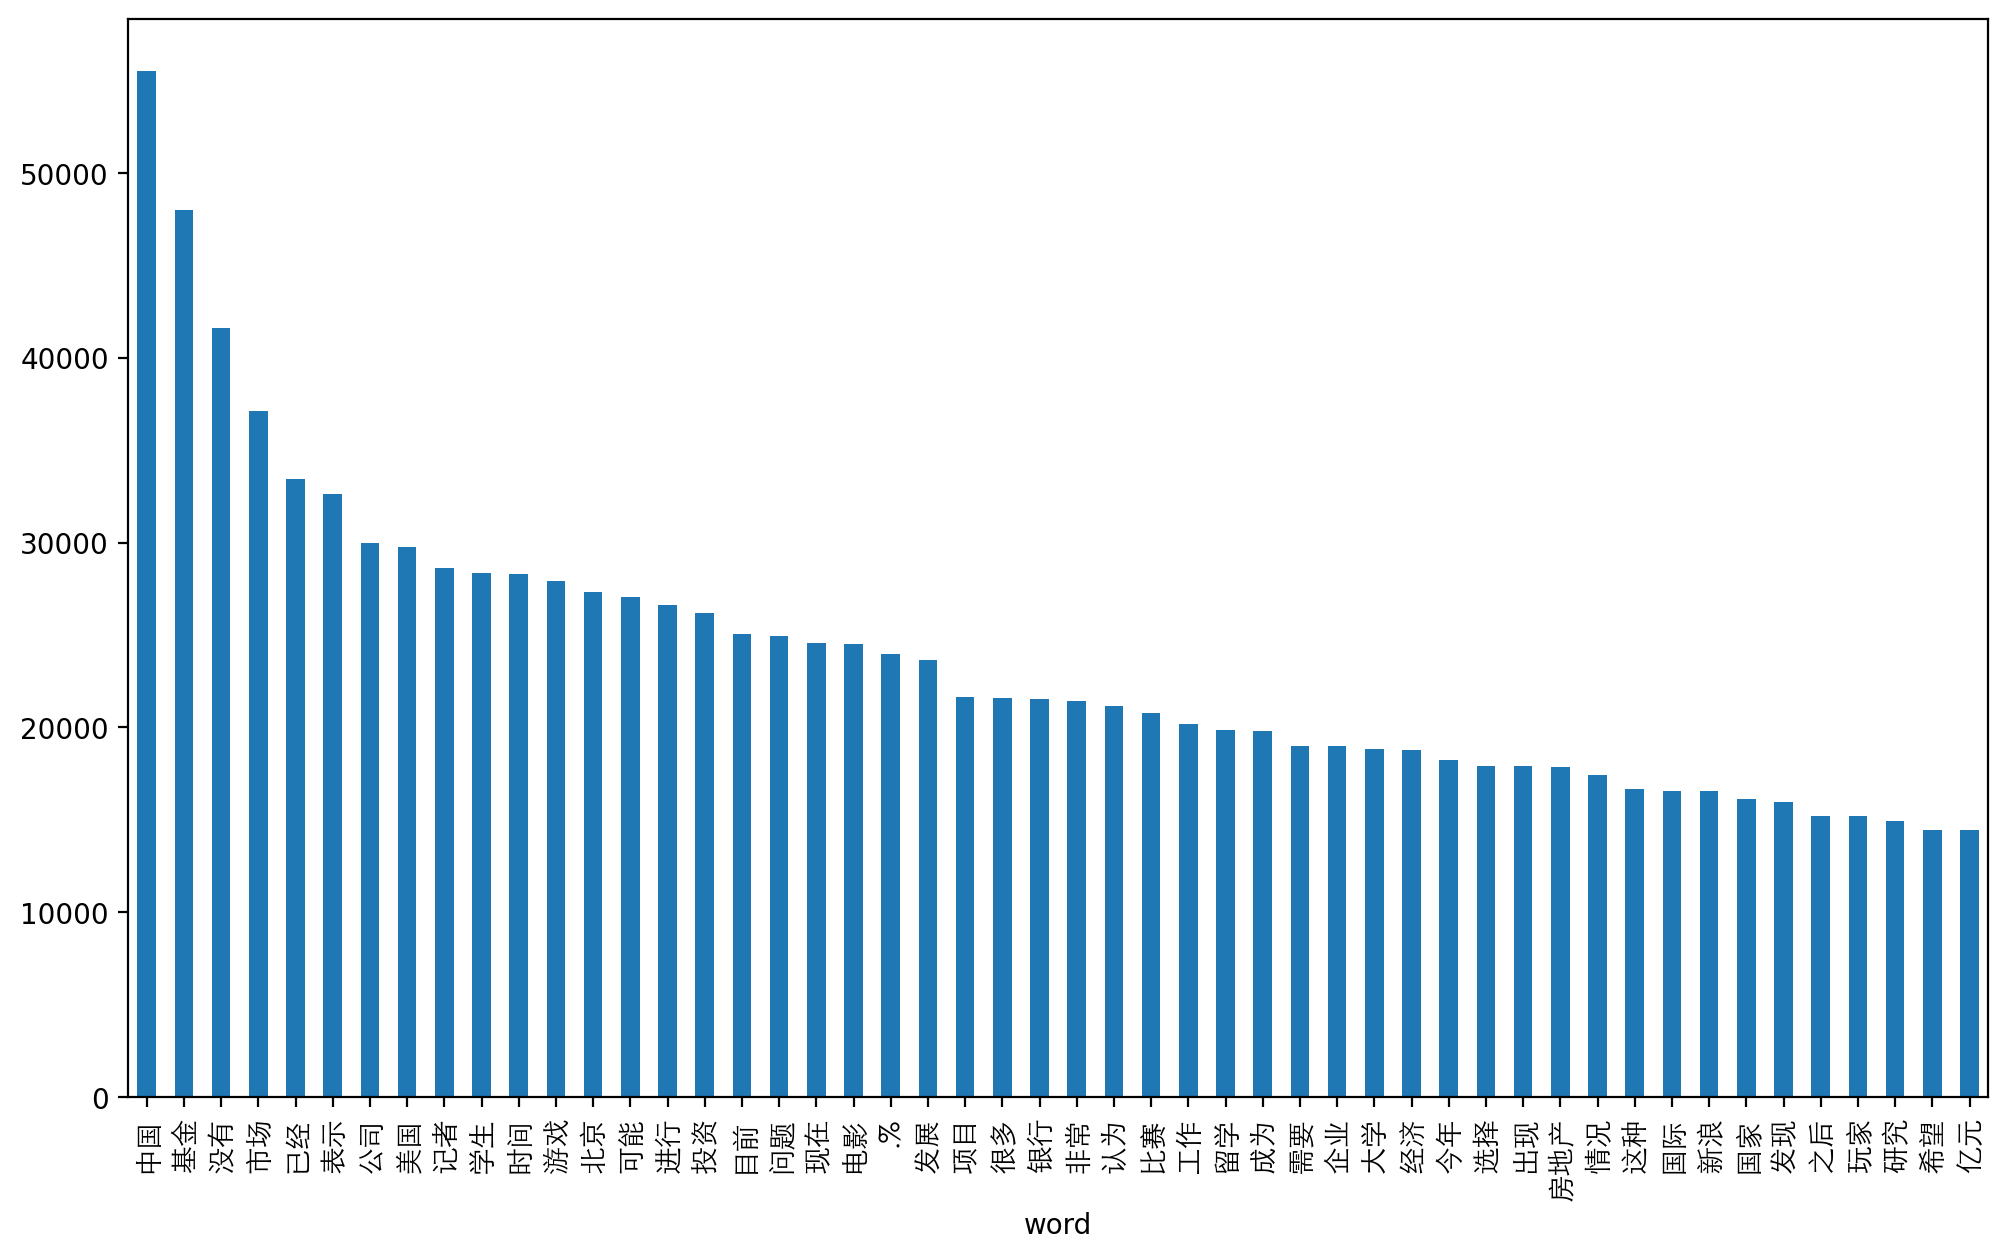

词典的词数: 20002
前10个单词:
 ['<unk>', '<pad>', '中国', '基金', '没有', '市场', '已经', '表示', '公司', '美国']
类别标签情况: Counter({'0': 5000, '1': 5000, '2': 5000, '3': 5000, '4': 5000, '5': 5000, '6': 5000, '7': 5000, '8': 5000, '9': 5000})


In [40]:
## 使用训练集构建单词表,没有预训练好的词项量
TEXT.build_vocab(traindata,max_size=20000,vectors = None)
LABEL.build_vocab(traindata)
## 可视化训练集中的前50个高频词
word_fre = TEXT.vocab.freqs.most_common(n=50)
word_fre = pd.DataFrame(data=word_fre,columns=["word","fre"])
word_fre.plot(x="word", y="fre", kind="bar",legend=False,figsize=(12,7))
plt.xticks(rotation = 90,fontproperties = fonts,size = 10)
plt.show()

print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
## 类别标签的数量和类别
print("类别标签情况:",LABEL.vocab.freqs)

多了 2 个词。这是因为 torchtext 默认会在词汇表中添加：
'<unk>'（索引 0）：代表未知词（OOV, Out-Of-Vocabulary）。
'<pad>'（索引 1）：用于填充短文本（因为你设置了 fix_length=400，需要 <pad>）。

In [41]:
## 定义一个迭代器，将类似长度的示例一起批处理。
BATCH_SIZE = 64
train_iter = data.BucketIterator(traindata,batch_size = BATCH_SIZE)
val_iter = data.BucketIterator(valdata,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)

In [42]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    if step > 0:
        break
## 针对一个batch 的数据，可以使用batch.labelcode获得数据的类别标签
print("数据的类别标签:\n",batch.labelcode)
## batch.cutword[0]是文本对应的标签向量
print("数据的尺寸:",batch.cutword[0].shape)
## batch.cutword[1] 对应每个batch使用的原始数据中的索引
print("数据样本数:",len(batch.cutword[1]))

数据的类别标签:
 tensor([5, 9, 9, 3, 9, 3, 5, 8, 1, 4, 0, 0, 7, 5, 6, 4, 5, 1, 5, 5, 0, 9, 1, 5,
        1, 8, 2, 2, 3, 6, 2, 9, 8, 2, 0, 5, 4, 8, 5, 3, 6, 6, 5, 4, 8, 4, 0, 2,
        0, 5, 9, 5, 9, 5, 3, 4, 7, 6, 5, 4, 6, 2, 4, 1])
数据的尺寸: torch.Size([64, 400])
数据样本数: 64


In [43]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    textdata,target = batch.cutword[0],batch.labelcode.view(-1)
    if step > 0:
        break
# ## 针对一个batch 的数据，可以使用batch.labelcode获得数据的类别标签
# print("数据的类别标签:\n",batch.labelcode)
# ## batch.cutword[0]是文本对应的标签向量
# print("数据的尺寸:",batch.cutword[0].shape)
# ## batch.cutword[1] 对应每个batch使用的原始数据中的索引
# print("数据样本数:",len(batch.cutword[1]))

## LSTM网络

In [46]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, layer_dim, output_dim):
        """
        vocab_size:词典长度
        embedding_dim:词向量的维度
        hidden_dim: RNN神经元个数
        layer_dim: RNN的层数
        output_dim:隐藏层输出的维度(分类的数量)
        """
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim ## RNN神经元个数
        self.layer_dim = layer_dim ## RNN的层数
        ## 对文本进行词项量处理
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM ＋ 全连接层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, layer_dim,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        embeds = self.embedding(x)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)   LSTM 有两个 hidden states, h_n 是分线（ht）, h_c 是主线（ct）
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.lstm(embeds, None)   # None 表示 hidden state h0 会用0初始化
        # 选取最后一个时间点的out输出
        out = self.fc1(r_out[:, -1, :]) 
        return out
    

In [ ]:
'''
### 1. 离散的单词编号

- **想象**：你有一本词典，每个单词都有一个号码。比如，“中国”对应号码 1，“美国”对应号码 2，依此类推。  
- **问题**：这些号码只是标签，没有告诉我们“中国”与“美国”之间有什么关系。数字 1 和 2 本身没有任何语义信息。

### 2. 嵌入层——一个查找表

- **概念**：嵌入层就像一个超级大查找表。  
- **工作方式**：查找表中，每个号码都对应着一个**向量**（一组数字），这个向量用来描述这个单词的“意思”。  
- **比喻**：想象你有一张卡片，上面写着“描述”这个单词的特征，比如“国家”、“经济”、“文化”等等，但这些特征用数字来表示。嵌入层就是把单词号码翻译成这样的一张卡片。

### 3. 如何转化为向量

- **查找过程**：  
  1. 你输入一个单词号码，比如 1（代表“中国”）。  
  2. 嵌入层查看查找表（一个大矩阵），找到第 1 行。  
  3. 第 1 行包含一串数字，比如 `[0.23, -0.45, 0.12, ...]`（如果词向量维度是 100，就有 100 个数字）。  
  4. 这个数字列表就是“中国”的向量表示。

- **学习过程**：  
  - 开始时，这个查找表里的所有数字都是随机的。  
  - 在模型训练过程中，通过不断地调整（优化）这些数字，让相似意思的单词（比如“中国”和“美国”）的向量变得更相似。这就是“学习到单词之间的关系”。

### 4. 为什么要转化为向量

- **便于数学运算**：  
  - 神经网络是用来处理数字的，而不是文字。  
  - 把单词变成一串数字后，模型可以利用这些数字进行数学计算（比如求相似度、加权求和等），从而“理解”文本。
  - 转换后的向量不仅仅是随机数字，而是通过训练逐渐变成了能够反映单词含义的信息。例如，模型可能学到“中国”和“美国”在很多上下文中是相似的，这两个单词的向量就会接近。
'''

In [47]:
vocab_size = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 128
layer_dim = 1
output_dim = 10
lstmmodel = LSTMNet(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim)
lstmmodel

LSTMNet(
  (embedding): Embedding(20002, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [49]:
## 定义网络的训练过程函数
def train_model2(model,traindataloader, valdataloader,criterion, 
                 optimizer,num_epochs=25,):
    """
    model:网络模型；traindataloader:训练数据集;
    valdataloader:验证数据集，;criterion：损失函数；optimizer：优化方法；
    num_epochs:训练的轮数
    """
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # 每个epoch有两个阶段,训练阶段和验证阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        model.train() ## 设置模型为训练模式
        for step,batch in enumerate(traindataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1) # 预测的标签
            loss = criterion(out, target) # 计算损失函数值
            optimizer.zero_grad()        
            loss.backward()       
            optimizer.step()  
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        
        ## 计算一个epoch的训练后在验证集上的损失和精度
        model.eval() ## 设置模型为训练模式评估模式 
        for step,batch in enumerate(valdataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out, target)   
            val_loss += loss.item() * len(target)
            val_corrects += torch.sum(pre_lab == target.data)
            val_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Val Loss: {:.4f}  Val Acc: {:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "train_acc_all":train_acc_all,
              "val_loss_all":val_loss_all,
              "val_acc_all":val_acc_all})  
    return model,train_process

In [50]:
# 定义优化器
optimizer = torch.optim.Adam(lstmmodel.parameters(), lr=0.0003)  
loss_func = nn.CrossEntropyLoss()   # 损失函数
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
lstmmodel,train_process = train_model2(
    lstmmodel,train_iter,val_iter,loss_func,optimizer,num_epochs=20)

----------
Epoch 0/19
0 Train Loss: 2.2635  Train Acc: 0.1377
0 Val Loss: 2.2438  Val Acc: 0.1276
----------
Epoch 1/19
1 Train Loss: 2.0062  Train Acc: 0.2504
1 Val Loss: 1.9763  Val Acc: 0.2622
----------
Epoch 2/19
2 Train Loss: 1.5968  Train Acc: 0.4001
2 Val Loss: 1.7513  Val Acc: 0.3552
----------
Epoch 3/19
3 Train Loss: 1.3691  Train Acc: 0.4851
3 Val Loss: 1.3592  Val Acc: 0.4902
----------
Epoch 4/19
4 Train Loss: 0.9915  Train Acc: 0.6567
4 Val Loss: 1.0678  Val Acc: 0.6428
----------
Epoch 5/19
5 Train Loss: 0.7191  Train Acc: 0.7730
5 Val Loss: 0.8552  Val Acc: 0.7524
----------
Epoch 6/19
6 Train Loss: 0.5030  Train Acc: 0.8594
6 Val Loss: 0.6285  Val Acc: 0.8210
----------
Epoch 7/19
7 Train Loss: 0.3666  Train Acc: 0.8988
7 Val Loss: 0.5859  Val Acc: 0.8276
----------
Epoch 8/19
8 Train Loss: 0.3427  Train Acc: 0.9024
8 Val Loss: 0.5749  Val Acc: 0.8360
----------
Epoch 9/19
9 Train Loss: 0.2593  Train Acc: 0.9293
9 Val Loss: 0.3833  Val Acc: 0.9026
----------
Epoch 10/

In [51]:
## 输出结果保存和数据保存
torch.save(lstmmodel,"/Users/xuqiuhua/Desktop/data/cnews/lstmmodel.pkl")
## 导入保存的模型
lstmmodel = torch.load("/Users/xuqiuhua/Desktop/data/cnews/lstmmodel.pkl")
lstmmodel
## 保存训练过程
train_process.to_csv("/Users/xuqiuhua/Desktop/data/cnews/lstmmodel_process.csv",index=False)
train_process

,epoch,train_loss_all,train_acc_all,val_loss_all,val_acc_all
0,0,2.263458,0.13766,2.243766,0.1276
1,1,2.006246,0.25036,1.976349,0.2622
2,2,1.596752,0.40012,1.751325,0.3552
3,3,1.369126,0.48506,1.359242,0.4902
4,4,0.991523,0.65668,1.067806,0.6428
5,5,0.719128,0.77298,0.855183,0.7524
6,6,0.502980,0.85944,0.628476,0.8210
7,7,0.366594,0.89876,0.585877,0.8276
8,8,0.342735,0.90240,0.574859,0.8360
9,9,0.259286,0.92934,0.383319,0.9026


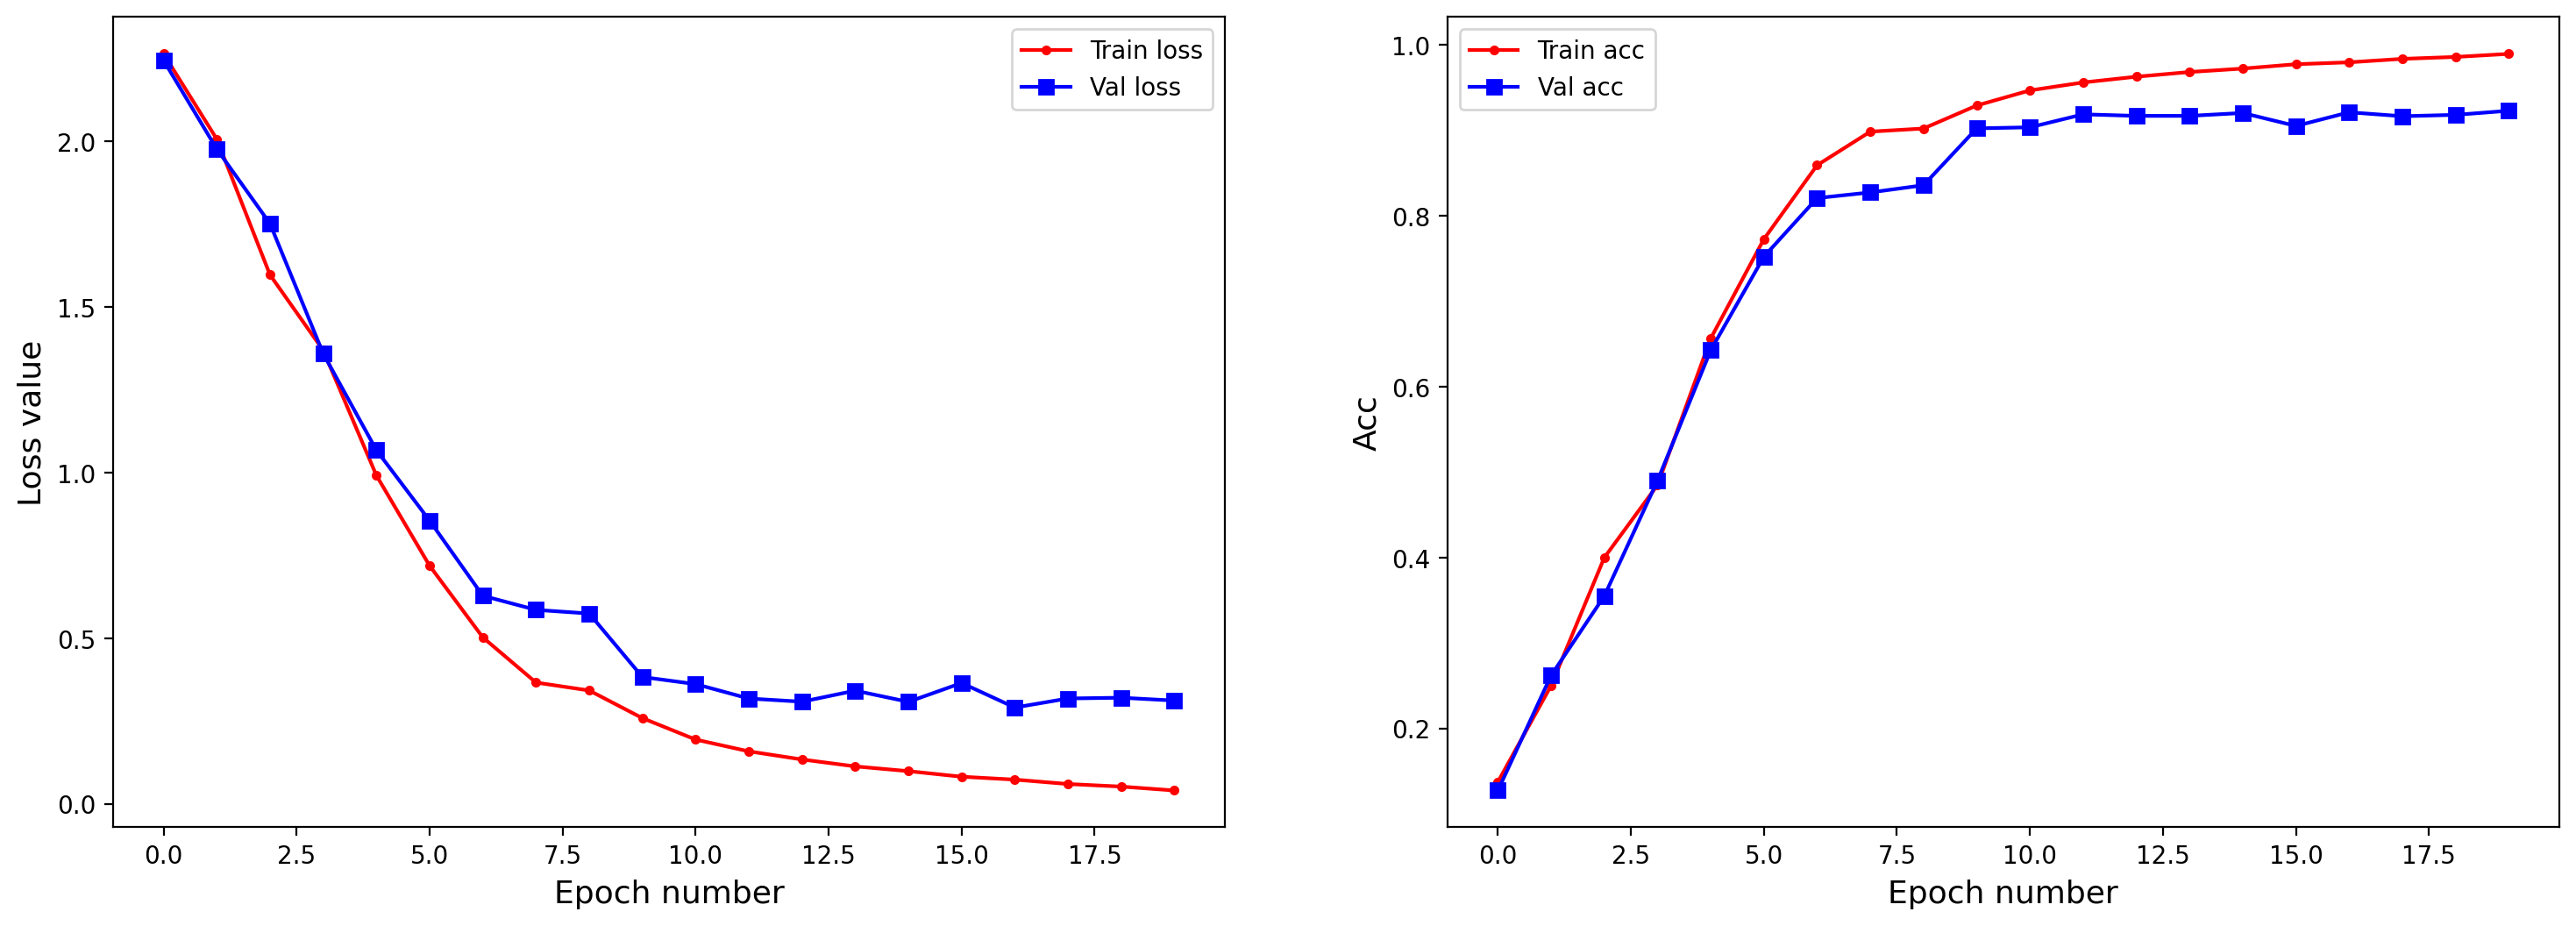

In [52]:
## 可视化模型训练过程中
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "r.-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Loss value",size = 13)
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "r.-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "bs-",label = "Val acc")
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Acc",size = 13)
plt.legend()
plt.show()

在测试集上的预测精度为: 0.9405


/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 23089 (\N{CJK UNIFIED IDEOGRAPH-5A31}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20048 (\N{CJK UNIFIED IDEOGRAPH-4E50}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/

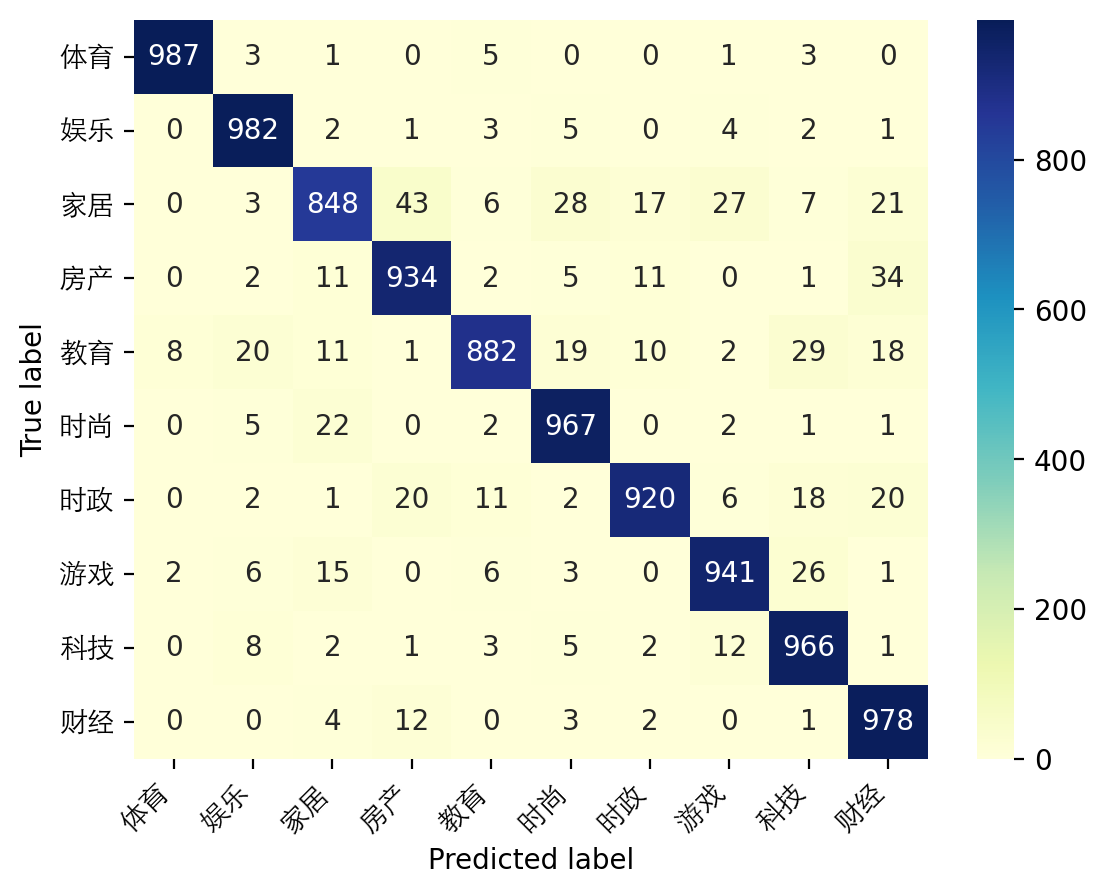

In [53]:
## 对测试集进行预测并计算精度
lstmmodel.eval() ## 设置模型为训练模式评估模式 
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,batch in enumerate(test_iter):
    textdata,target = batch.cutword[0],batch.labelcode.view(-1)
    out = lstmmodel(textdata)
    pre_lab = torch.argmax(out,1)
    test_y_all = torch.cat((test_y_all,target)) ##测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab))##测试集的预测标签

acc = accuracy_score(test_y_all,pre_lab_all)
print("在测试集上的预测精度为:",acc)
## 计算混淆矩阵并可视化
class_label = ["体育","娱乐","家居","房产","教育",
               "时尚","时政","游戏","科技","财经"]
conf_mat = confusion_matrix(test_y_all,pre_lab_all)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right',fontproperties = fonts)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right',fontproperties = fonts)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 23089 (\N{CJK UNIFIED IDEOGRAPH-5A31}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20048 (\N{CJK UNIFIED IDEOGRAPH-4E50}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/seaborn/utils.py:84: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.draw()
/Users/xuqiuhua/opt/

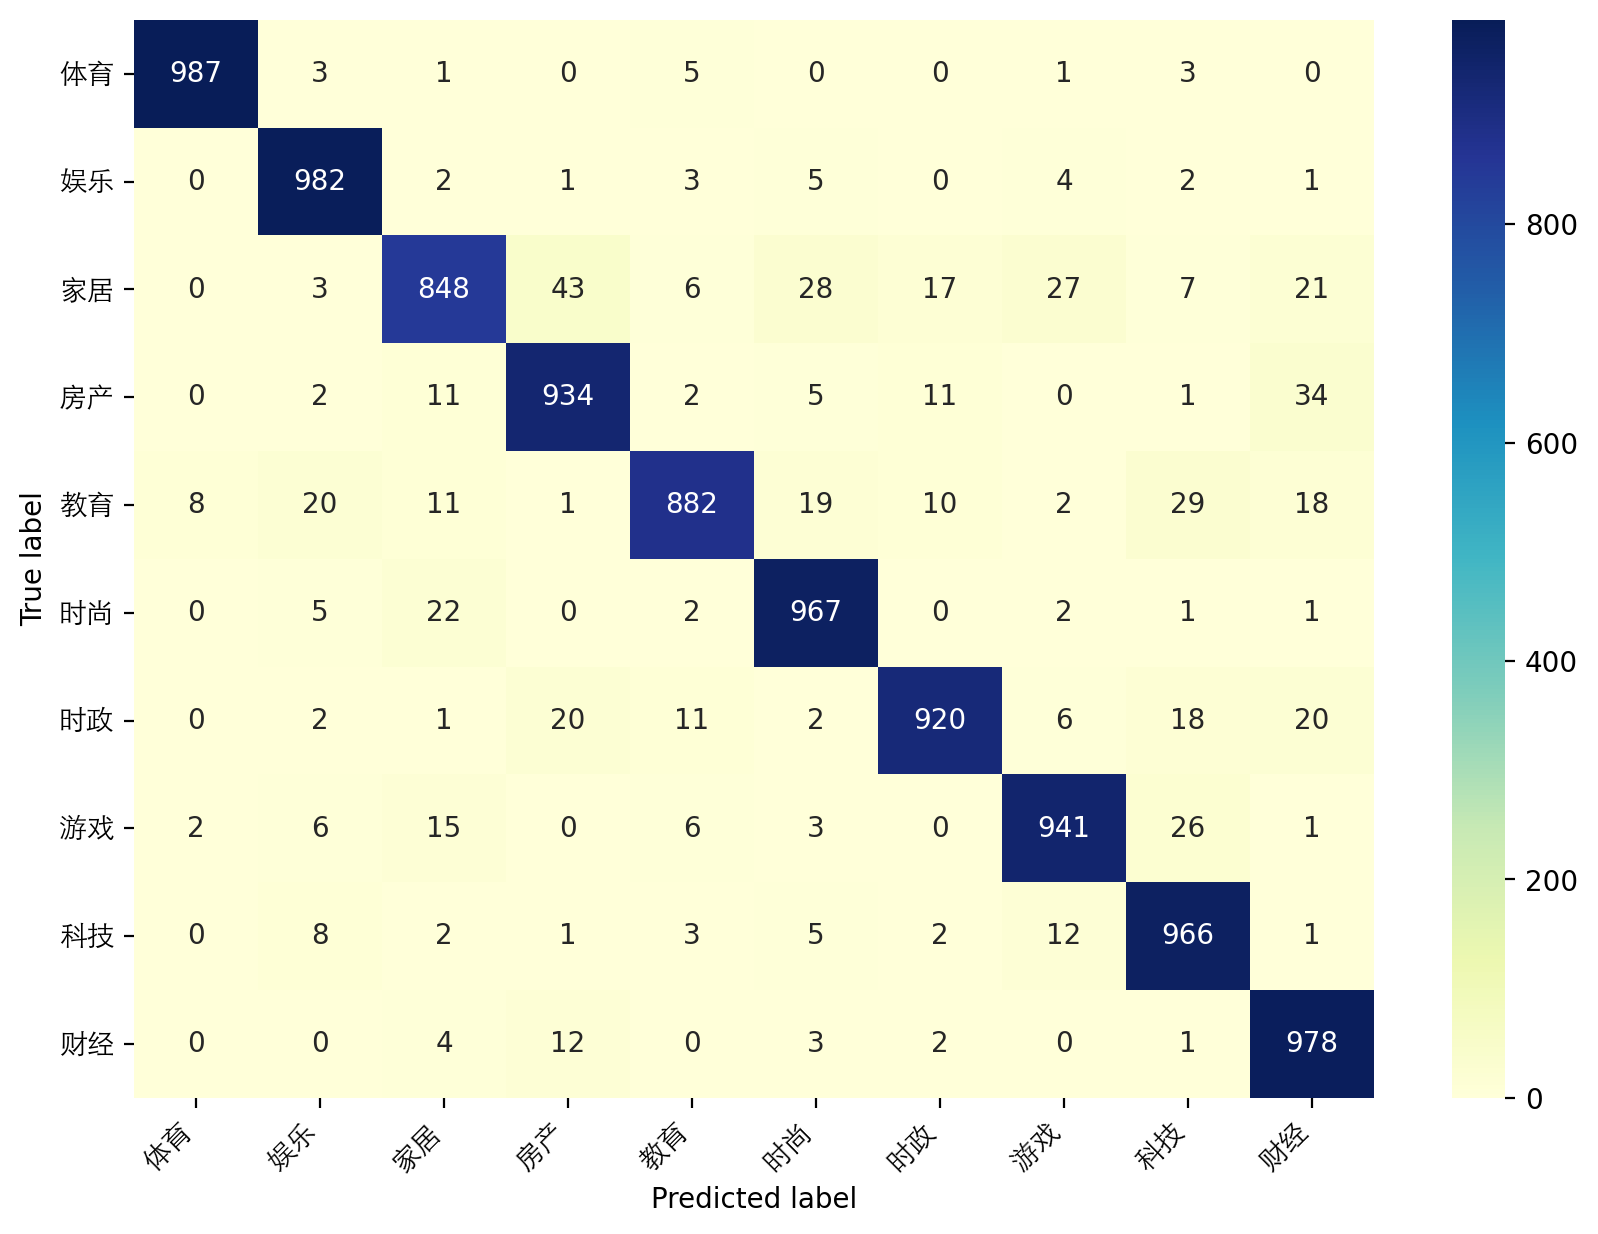

In [54]:
plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right',fontproperties = fonts)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right',fontproperties = fonts)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

###  可视化训练得到的词向量

In [55]:
from sklearn.manifold import TSNE

In [56]:
## 导入保存的模型
lstmmodel = torch.load("/Users/xuqiuhua/Desktop/data/cnews/lstmmodel.pkl")
lstmmodel

LSTMNet(
  (embedding): Embedding(20002, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [57]:
## 获取词向量
word2vec  = lstmmodel.embedding.weight
## 词向量对应的词
words = TEXT.vocab.itos
## 使用t-sne对词向量降维并可视化所有词的分布
tsne = TSNE(n_components=2,random_state=123)
word2vec_tsne = tsne.fit_transform(word2vec.data.numpy())

/Users/xuqiuhua/opt/anaconda3/envs/mynlp2/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


降维后的二维散点图展示了所有词的分布情况。每个点代表一个词，点与点之间的距离表示它们在语义空间中的相似度。
相似的单词在图中应该比较靠近，例如“体育”和“游戏”可能会位于相邻的区域。
不相似的单词会远离，比如“体育”和“科技”可能会分布在图的不同区域。

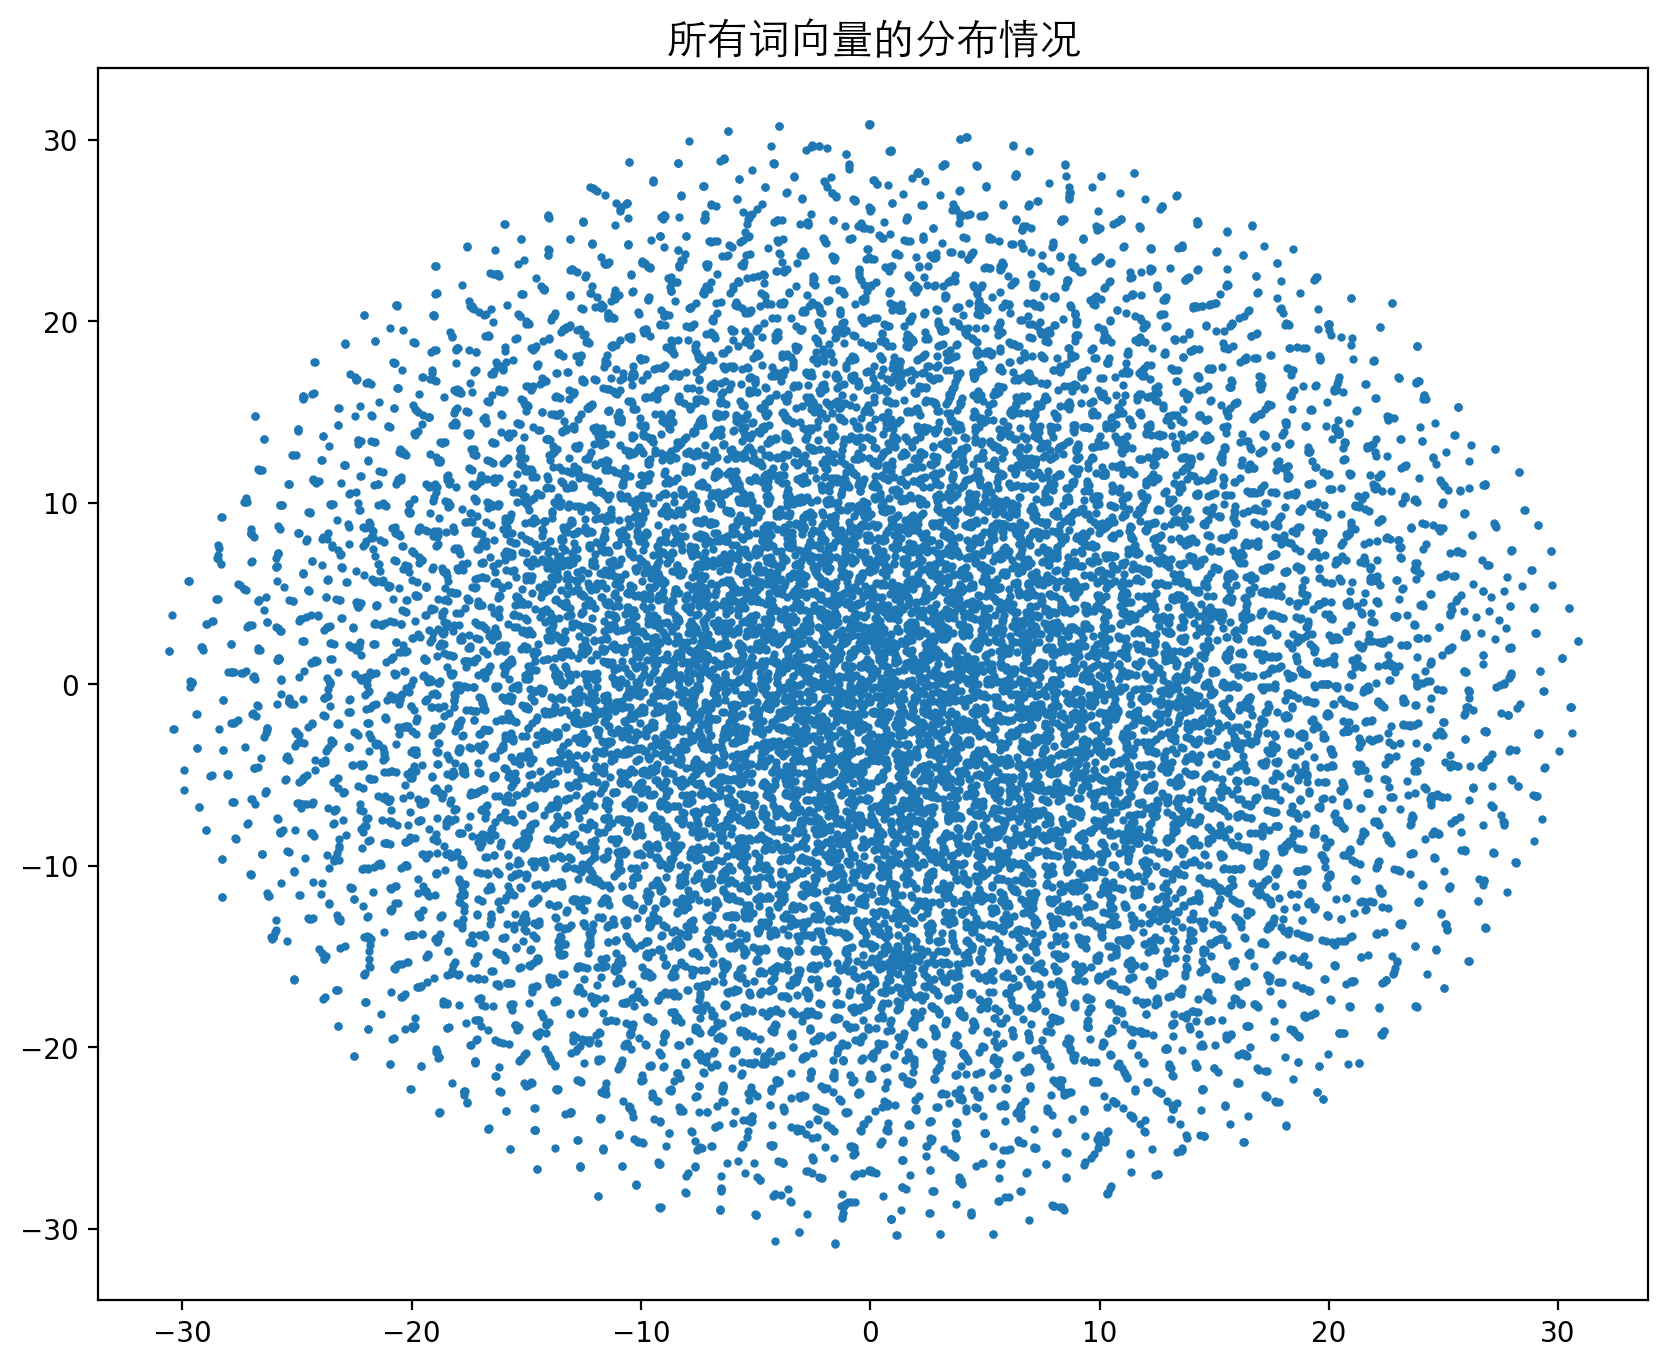

In [58]:
## 使用散点图可视化分布情况
plt.figure(figsize = (10,8))
plt.scatter(word2vec_tsne[:,0],word2vec_tsne[:,1],s=4)
plt.title("所有词向量的分布情况",fontproperties = fonts,size = 15)
plt.show()

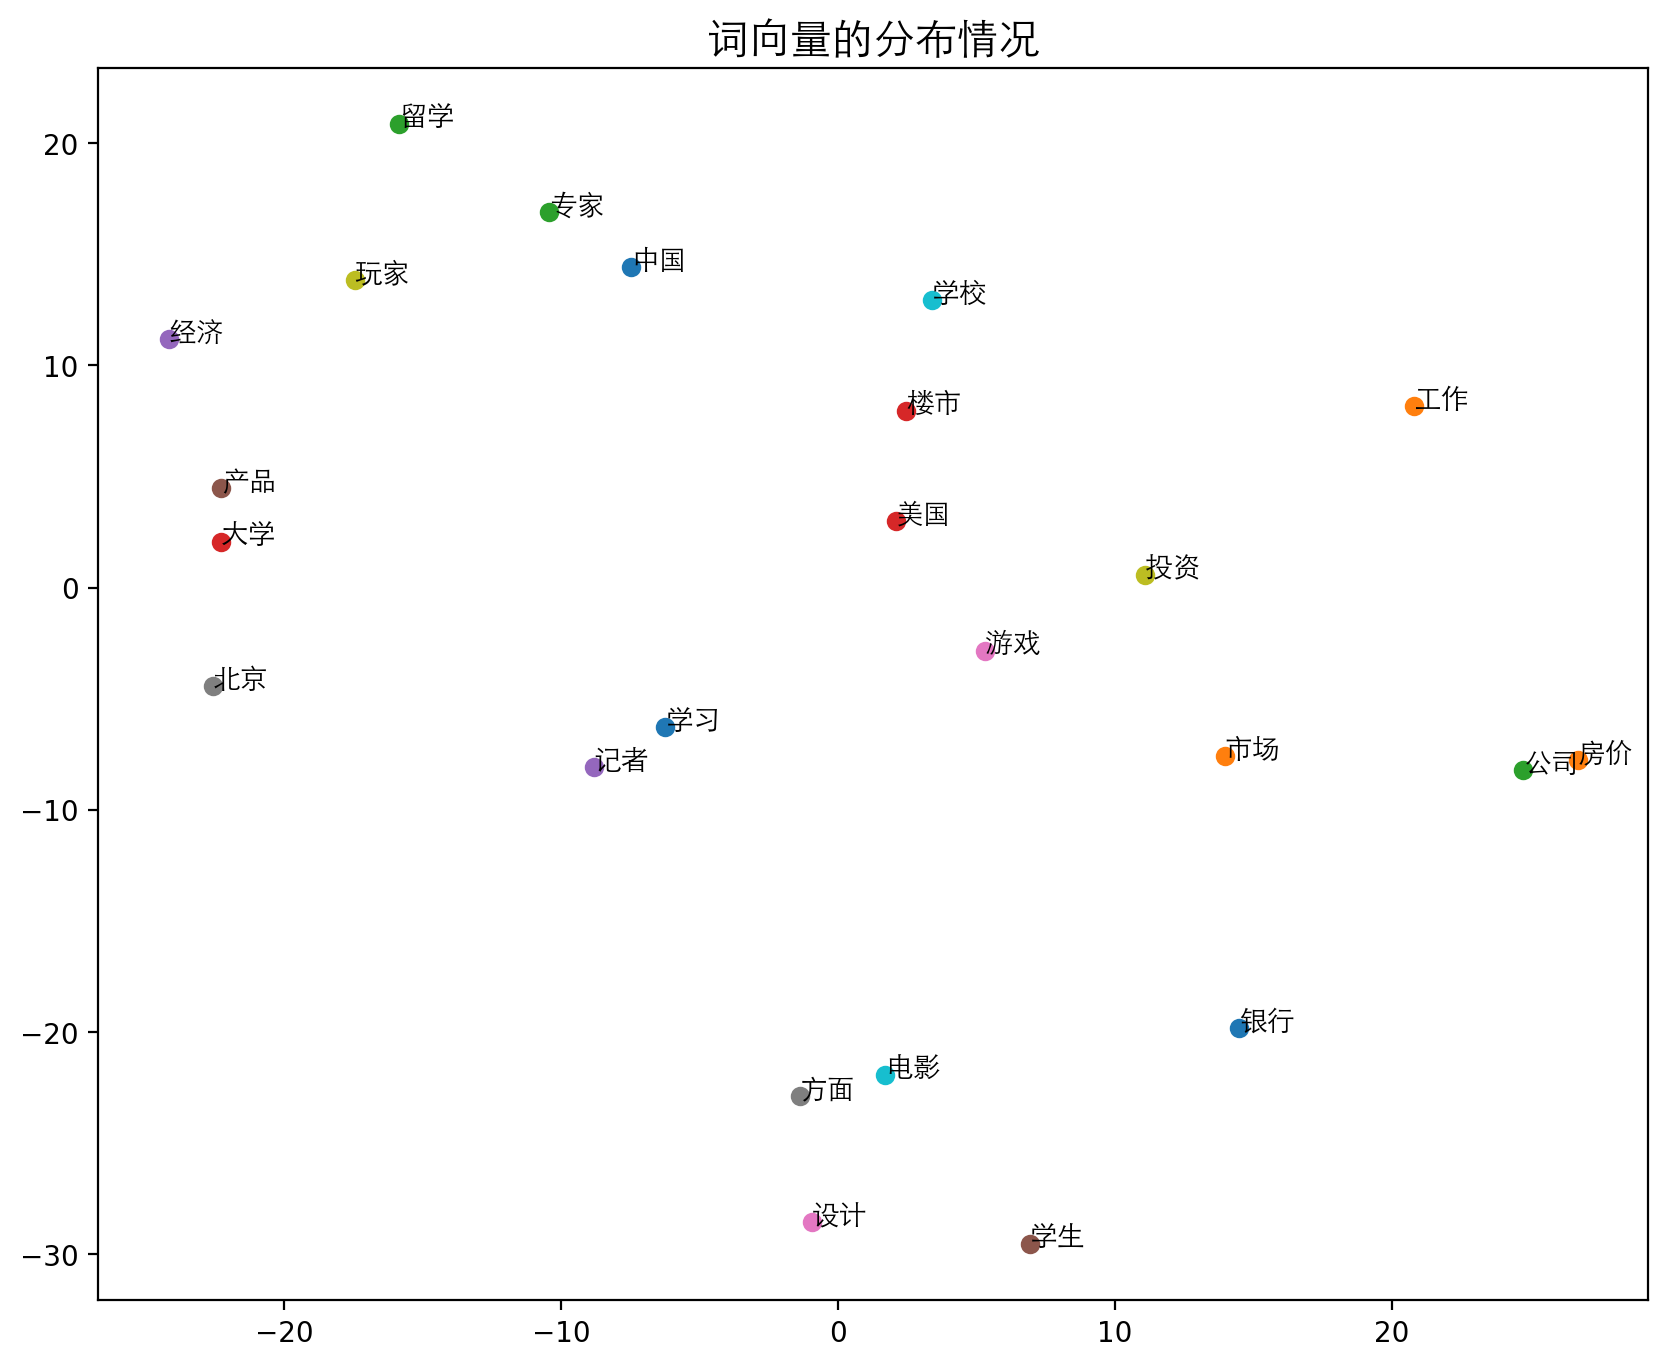

In [59]:
## 可视化部分感兴趣词的分布情况
vis_word = ["中国","市场","公司","美国","记者","学生","游戏","北京",
            "投资","电影","银行","工作","留学","大学","经济","产品",
            "设计","方面","玩家","学校","学习","房价","专家","楼市"]
## 计算词语在词向量中的索引
vis_word_index = [words.index(ii) for ii in vis_word]
plt.figure(figsize = (10,8))
for ii,index in enumerate(vis_word_index):
    plt.scatter(word2vec_tsne[index,0],word2vec_tsne[index,1])
    plt.text(word2vec_tsne[index,0],word2vec_tsne[index,1],vis_word[ii],
            fontproperties = fonts)
plt.title("词向量的分布情况",fontproperties = fonts,size = 15)
plt.show()